# LOWESS Method for extracting trend from Time Series

LOWESS stands for ***Lo**cally **We**ighted Regression and **S**moothing **S**catterplots. It is a method to fit a smooth curve to a scatter plot. It can be use to extract the trend term in time series.

***Pros***:
1. Unlike moving average, it is robust to outliers
2. Unlike moving average, there will be no missing data at the edges
3. It is interpretable
4. No assumption is made about the underlying data for extracting trend. As long as we choose a good fraction of data for making roubust regression, we will be able to avoid over-smoothing the data.


***Cons***:
1. Since this method requires to access the entire data set to evaluate curve at any point, it is slow to fit on large datasets.
2. Selecting a good fraction of data for making robus regression is challenging. Sometimes it requires manual inspection. Cross validation can also be a candidate for finding good fraction of data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.nonparametric.smoothers_lowess import lowess

import sys
sys.path.append('../')

import gen_synthetic_ts as gst

#### Generate synthetic time series

In [3]:
# get the synthetic timeserie

df_ts = gst.generate_synthetic_ts()
df_ts

,trend,seasonality,residual,DateTime,Value
0,0.000,5.082107,1.461450,2010-01-01,6.543557
1,0.001,5.279406,2.704887,2010-01-02,7.985293
2,0.002,5.463582,2.952176,2010-01-03,8.417758
3,0.003,5.631210,1.210661,2010-01-04,6.844871
4,0.004,5.779161,-0.196897,2010-01-05,5.586264
...,...,...,...,...,...
1455,1.455,14.655923,0.760019,2013-12-26,16.870942
1456,1.456,15.432413,0.793592,2013-12-27,17.682004
1457,1.457,16.201044,1.438552,2013-12-28,19.096596
1458,1.458,16.950705,2.640163,2013-12-29,21.048869


### Visualize time series componentes

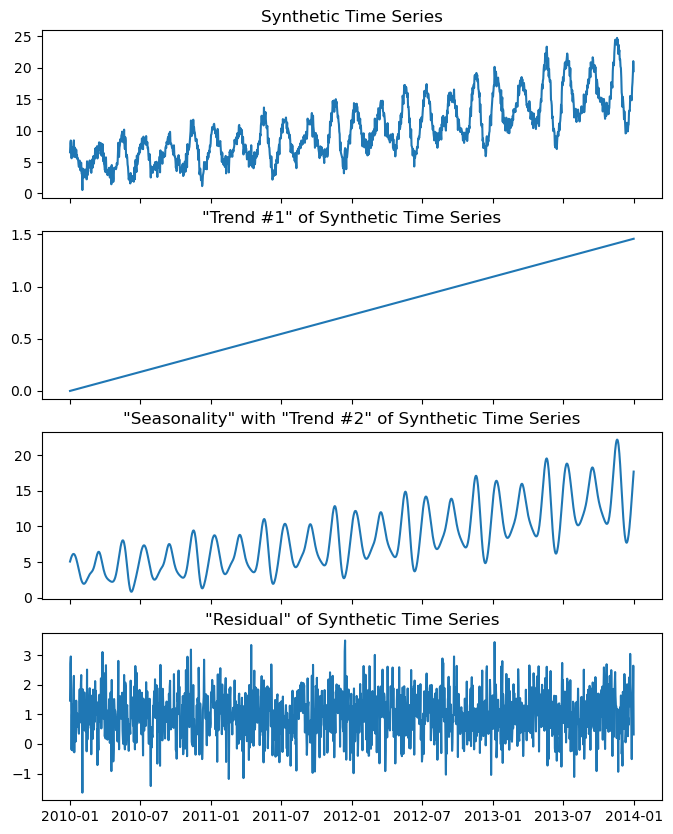

In [18]:
fig, axes = plt.subplots(figsize=(8, 10), nrows=4, ncols=1, sharex=True)

axes[0].plot(df_ts['DateTime'], df_ts['Value'])
axes[0].set_title('Synthetic Time Series')
axes[1].plot(df_ts['DateTime'], df_ts['trend'])
axes[1].set_title('"Trend #1" of Synthetic Time Series')
axes[2].plot(df_ts['DateTime'], df_ts['seasonality'])
axes[2].set_title('"Seasonality" with "Trend #2" of Synthetic Time Series')
axes[3].plot(df_ts['DateTime'], df_ts['residual'])
axes[3].set_title('"Residual" of Synthetic Time Series')
plt.show()

#### Apply LOWESS on time series

In [14]:
frac_lst = [0.04, 0.10, 0.16, 0.3, 0.6]

for frac in frac_lst:
    res = lowess(
        endog=df_ts['Value'], 
        exog=np.arange(0, len(df_ts)),  # input of the lowess should be numpy array and a numeric type
        frac=frac, # fraction of data to be use in window for fitting roubust linear regression
        it=3 # number of iteration for robust regression.
    )

    df_ts[f'lowess_frac_{frac}'] = res[:, 1]#.copy()

In [15]:
df_ts

,trend,seasonality,residual,DateTime,Value,lowess_frac_0.04,lowess_frac_0.1,lowess_frac_0.15,lowess_frac_0.3,lowess_frac_0.6,lowess_frac_0.16
0,0.000,5.082107,1.461450,2010-01-01,6.543557,7.731840,5.734669,5.372079,4.932975,4.619085,5.305922
1,0.001,5.279406,2.704887,2010-01-02,7.985293,7.614314,5.720895,5.367969,4.936402,4.624958,5.303044
2,0.002,5.463582,2.952176,2010-01-03,8.417758,7.496690,5.707287,5.363913,4.939837,4.630833,5.300213
3,0.003,5.631210,1.210661,2010-01-04,6.844871,7.378997,5.693844,5.359910,4.943280,4.636710,5.297429
4,0.004,5.779161,-0.196897,2010-01-05,5.586264,7.261257,5.680564,5.355959,4.946730,4.642588,5.294692
...,...,...,...,...,...,...,...,...,...,...,...
1455,1.455,14.655923,0.760019,2013-12-26,16.870942,12.110794,15.287549,15.864888,16.618140,16.851808,15.970809
1456,1.456,15.432413,0.793592,2013-12-27,17.682004,11.983974,15.267747,15.861075,16.625960,16.861884,15.968825
1457,1.457,16.201044,1.438552,2013-12-28,19.096596,11.861776,15.247809,15.857195,16.633770,16.871959,15.966780
1458,1.458,16.950705,2.640163,2013-12-29,21.048869,11.743977,15.227743,15.853248,16.641569,16.882033,15.964675


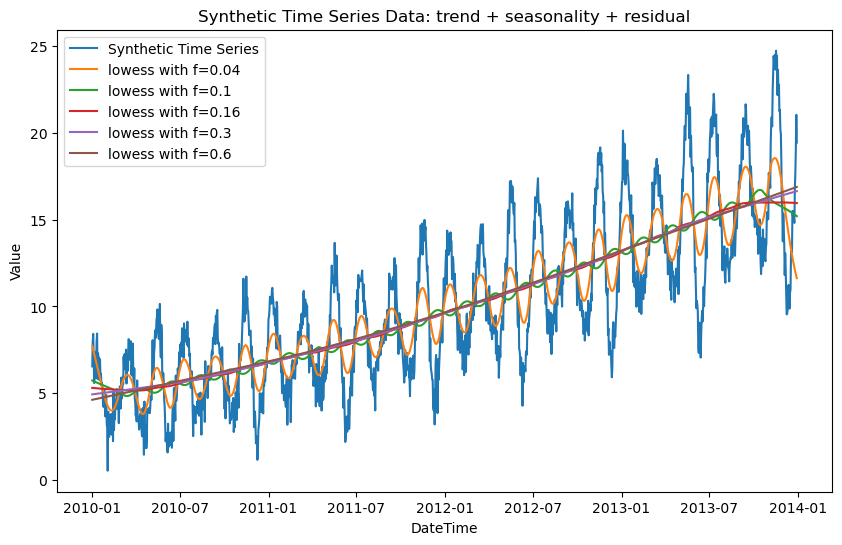

In [16]:
#Plot the synthetic time series
plt.figure(figsize=(10, 6))
plt.plot(df_ts['DateTime'], df_ts['Value'], label='Synthetic Time Series')

for frac in frac_lst:
    plt.plot(df_ts['DateTime'], df_ts[f'lowess_frac_{frac}'], label=f'lowess with f={frac}')
plt.xlabel('DateTime')
plt.ylabel('Value')
plt.title('Synthetic Time Series Data: trend + seasonality + residual')
plt.legend()
plt.show()

#### Perfrom KFold Cross validation for finding best `fraction` of data for roubust regression ....

In [8]:
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error as rmse

In [9]:
X = np.arange(0, len(df_ts))
y = df_ts['Value'].values

cv_score_by_frac = dict()
for frac in np.arange(0.08, 1.02, 0.02):
    
    cv_results = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for trn_idx, vld_idx in kf.split(X, y):
        X_trn, y_trn = X[trn_idx], y[trn_idx]
        X_vld, y_vld = X[vld_idx], y[vld_idx]

        # comput lowess fit
        y_pred = lowess(
            endog = y_trn,
            exog = X_trn,
            frac = np.round(frac, 2),
            xvals = X_vld # return prediction on the X_vld only.
        )

        loss = rmse(y_vld, y_pred)
        cv_results.append(loss)


    cv_score_mean = np.mean(cv_results)
    cv_score_by_frac[frac] = cv_score_mean


results = pd.Series(cv_score_by_frac)

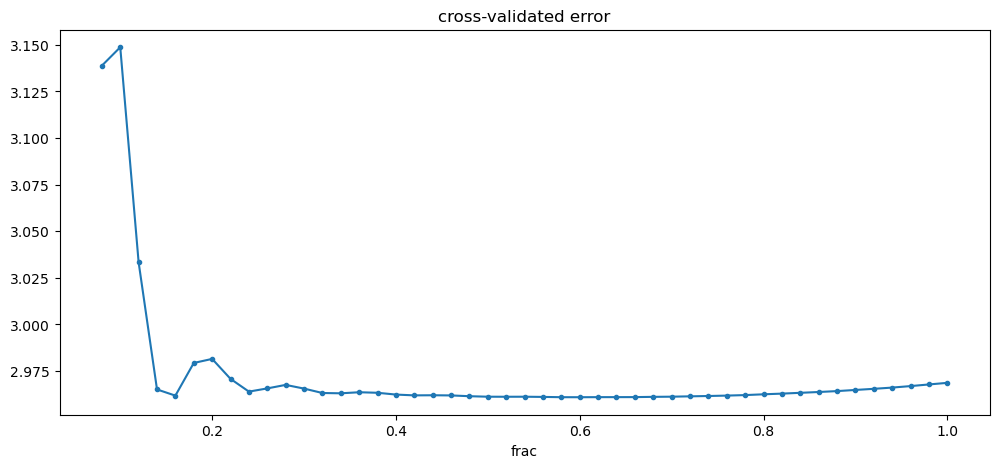

In [10]:
ax = results.plot(marker='.', figsize=[12, 5])
ax.set_xlabel('frac')
ax.set_title('cross-validated error')
plt.show()

In [11]:
results[results == results.min()]

0.6    2.96098
dtype: float64

In [13]:
results.head(10)

0.08    3.138808
0.10    3.148702
0.12    3.033318
0.14    2.965152
0.16    2.961837
0.18    2.979354
0.20    2.981533
0.22    2.970818
0.24    2.963988
0.26    2.965706
dtype: float64